# Package Installation for Snowflake Connection and Data Processing

In [1]:
!pip install  dask[complete]  snowflake  snowflake-connector-python snowflake-snowpark-python snowflake-snowpark-python[pandas] seaborn matplotlib numpy pandas scikit-learn  fosforml plotly

You should consider upgrading via the 'pip install --upgrade pip' command.


# Import necessary libraries

In [2]:
# Importing general libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import seaborn as sns  # For data visualization
from datetime import datetime  # For date and time manipulation
import matplotlib.pyplot as plt  # For plotting graphs

# Importing Snowflake session management
from snowflake.snowpark.session import Session  # For Snowflake integration

# Importing advanced plotting libraries
from plotly.subplots import make_subplots  # For creating subplots in Plotly
import plotly.graph_objects as go  # For creating interactive visualizations with Plotly
import plotly.express as px  # For simplified plotting using Plotly

# Setting Pandas display option to show more columns in the output
pd.set_option('display.max_columns', 100)

# Importing libraries for machine learning and feature selection
from sklearn.ensemble import RandomForestClassifier  # For Random Forest model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc  # For model evaluation metrics
from sklearn.feature_selection import SelectKBest, f_classif  # For feature selection
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder  # For encoding categorical data and scaling
from sklearn.impute import SimpleImputer  # For handling missing values
from sklearn.compose import ColumnTransformer  # For applying different preprocessing steps to different columns
from sklearn.pipeline import Pipeline  # For creating machine learning pipelines
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # For splitting data and performing grid search for hyperparameter tuning

# Importing additional libraries for visualization and matplotlib handling
import matplotlib.pyplot as plt  # For plotting static visualizations

# Setting up environment for plotting using Seaborn and Matplotlib
sns.set(style="whitegrid")  # Setting the style for Seaborn plots


# This section connects to Snowflake using fosforml's Snowflake session manager, retrieves data from a specified Snowflake table, and loads the data into a Pandas DataFrame for further processing and modeling.

In [3]:

# Importing the get_session function from fosforml's Snowflake session manager
from fosforml.model_manager.snowflakesession import get_session

# Establishing a Snowflake session for executing queries and performing operations
my_session = get_session()

# Define the name of the Snowflake table to query
table_name = 'ORDER_DATA_TRAINING'

# Execute a SQL query to select all records from the specified table in Snowflake
df_sample = my_session.sql("select * from {}".format(table_name)).to_pandas()

# Filtering and Preparing the Training Dataset for Returned Status Analysis

In [4]:
# Import Dask for handling larger datasets efficiently
import dask.dataframe as dd

#  Dask DataFrame allows for efficient handling of large datasets and delayed execution
df_sample_dask = dd.from_pandas(df_sample, npartitions=4)  # Adjust npartitions based on data size and memory

#  We use Dask to filter the records based on the 'RETURNED_STATUS' column
df_train_dask = df_sample_dask[df_sample_dask['RETURNED_STATUS'].isin(['CANCELLED', 'RETURNED', 'DELIVERED', 'IN PROCESS'])]

#  Dask performs lazy computation, so we need to explicitly call .compute() to trigger the actual computation
df_train = df_train_dask.compute()

#  Display the count of each 'RETURNED_STATUS' to verify the filtering step
print(df_train['RETURNED_STATUS'].value_counts())


RETURNED_STATUS
CANCELLED     10000
DELIVERED     10000
IN PROCESS    10000
RETURNED      10000
Name: count, dtype: int64[pyarrow]


# Creating a Binary Target Variable for Classification

In [5]:
# If the 'RETURNED_STATUS' is 'CANCELLED' or 'RETURNED', assign 1, else assign 0
df_train['TARGET'] = df_train['RETURNED_STATUS'].apply(lambda x: 1 if x in ['CANCELLED', 'RETURNED'] else 0)


# This will give us an understanding of how many records are marked as 1 (CANCELLED/RETURNED) or 0 (DELIVERED/IN PROCESS)
target_counts = df_train['TARGET'].value_counts()

# Display the count of each target class
print(target_counts)


TARGET
1    20000
0    20000
Name: count, dtype: int64


In [6]:
df_train

,DIVISION_CODE,DIVISION_NAME,BRAND_CODE,BRAND_NAME,CLASS_CODE,CLASS_NAME,SELLING_CHANNEL,CHAIN,WEB_ORDER_NUMBER,OMS_ORDER_NUMBER,OMS_LINE_ITEM_ID,OMS_TICKET_ID,SKU_ID,QUANTITY,UNIT_PRICE,CURRENT_STATUS,CURRENT_STATUS_DESCRIPTION,TRANSACTION_DATE,SHIP_FROM_WAREHOUSE_CODE,SHIP_FROM_WAREHOUSE_DESCRIPTION,ORDER_DATE,READY_TO_PRINT_DATE,PRINT_TICKET_DATE,VERIFIED_SHIPPED_DATE,BACK_ORDERED_DATE,ORDER_AGE,GIFT_ARTICLE_FLAG,CARRIER_NAME,CARRIER_TRACKING_NUMBER,DROPSHIP_FLAG,ORDER_STATUS,ORDER_CREATION_DATE,ORDER_CONFIRMATION_DATE,WM_ORDER_ID,WM_ORDER_LINE_ID,WM_ORDER_STATUS,WM_PICKING_START_TIME,WM_PICKING_END_TIME,WM_PICKING_AGE,WM_PACKING_START_TIME,WM_PACKING_END_TIME,WM_PACKING_AGE,WM_CREATED_DATE,WM_UPDATED_DATE,WM_SHIPPED_DATE,WM_ORDER_AGE,STORE_ID,STORE_NAME,SHIP_METHOD_CODE,SHIP_METHOD_NAME,SHIP_METHOD_SERVICE,SHIPMENT_SLA,NEW_ORDER_DATE,RETURN_REASON,RETURN_FLAG,RECORD_DATE,RECORD_TIME,GROSS_SALES,RETURNED_STATUS,SHIPPING_DELAY,TARGET
0,44,Men's,10788,Boglioli,121,Suit,Store_POS,Chain1,SP0100009809137030724,51963676,51963676*1,51963676-3,301226252875,1,1275.0,Cancelled,Cancelled,2024-03-09,5,Oakbrook,2024-09-04,2024-03-08 11:10:47,2024-03-08 13:00:00,NaT,<NA>,2,false,<NA>,<NA>,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2024-07-04,NaN,6247,NA,<NA>,<NA>,GROUND,NaN,2022-08-25,<NA>,<NA>,<NA>,<NA>,1275,CANCELLED,False,1
1,44,Men's,10864,Brunello Cucinelli,6,Denim,Others,Chain1,STA000000000541002,51890073,51890073*1,51890073-2,301230618773,1,340.0,Cancelled,Cancelled,2024-03-04,5,Oakbrook,2024-10-14,2024-03-01 20:02:26,2024-03-01 13:00:00,NaT,01-03-2024,3,false,<NA>,<NA>,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2024-08-14,NaN,6247,NA,<NA>,<NA>,GROUND,NaN,2024-02-14,<NA>,<NA>,<NA>,<NA>,340,CANCELLED,False,1
2,56,Jewelry,45788,LIE STUDIO,36,Earrings,Online,Chain2,WC200001273540,51896750,51896750*1,51896750-2,301236804934,1,250.0,Cancelled,Cancelled,2024-03-05,3,Tampa Bay,2023-11-12,2024-03-02 13:00:00,2024-03-02 13:00:00,NaT,05-03-2024,3,false,FedEx,<NA>,false,NA,1900-01-01,1900-01-01,<NA>,******,Not in MAO,NaT,NaT,NaN,NaT,NaT,NaN,1900-01-01,1900-01-01,1900-01-01,-9999.0,6060,NA,FEDXH,FedEx Home Delivery,GROUND,NaN,2023-03-12,<NA>,<NA>,<NA>,<NA>,250,CANCELLED,False,1
3,98,Non Retail,11078,Chanel,54,Sandals,Store_POS,Chain1,SP0100003304177032024,52123853,52123853*1,52123853-2,301237490259,1,1475.0,Cancelled,Cancelled,2024-03-20,6,STORES,2023-05-05,2024-03-20 13:00:00,2024-03-20 13:00:00,NaT,20-03-2024,0,false,<NA>,<NA>,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2023-03-05,NaN,9010,Los Angeles,PAC2,PacMan 2nd Day,2ND DAY,NaN,2022-09-05,<NA>,<NA>,<NA>,<NA>,1475,CANCELLED,False,1
4,53,Beauty,14510,ROC,995,GWP's,Online,Chain1,WC100004239069,52048953,52048953*2,52048953-2,301240889026,1,0.0,Cancelled,Cancelled,2024-03-15,3,Tampa Bay,2024-06-14,2024-03-14 13:00:00,2024-03-14 13:00:00,NaT,15-03-2024,1,true,Need it Now,<NA>,false,NA,1900-01-01,1900-01-01,<NA>,******,Not in MAO,NaT,NaT,NaN,NaT,NaT,NaN,1900-01-01,1900-01-01,1900-01-01,-9999.0,6060,NA,NDTN3,Need it Now,GROUND,NaN,2023-10-14,<NA>,<NA>,<NA>,<NA>,0,CANCELLED,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,34,Ladies Shoes,11135,Christian Louboutin,54,Sandals,Online,Chain1,WC100004207804,52001186,52001186*2,52001186-1,301233262416,-1,1195.0,Ready to Ship,Returned,2024-03-28,5,Oakbrook,2024-01-19,2024-03-12 12:26:05,2024-03-12 13:16:47,NaT,<NA>,18,false,FedEx SmartPost,******08155361239845,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2023-11-19,NaN,6247,NA,FXPOS,FedEx SmartPost,GROUND,NaN,2023-05-19,Size Issues,<NA>,<NA>,<NA>,-1195,RETURNED,False,1
39996,11,Women's Apparel,13657,Misook,124,Dress,Online,Chain1,WC100004227187,52030192,52030192*5,52030192-2,301228013924,-1,348.0,Ready to

In [7]:
df_train['SHIPPING_DELAY']

0        False
1        False
2        False
3        False
4        False
         ...  
39995    False
39996    False
39997    False
39998    False
39999    False
Name: SHIPPING_DELAY, Length: 40000, dtype: bool

In [8]:
df_train = df_train.groupby('RETURNED_STATUS').apply(lambda x: x.sample(n=2500, replace=False))

# Reset index after sampling
df_train = df_train.reset_index(drop=True)


df_train

,DIVISION_CODE,DIVISION_NAME,BRAND_CODE,BRAND_NAME,CLASS_CODE,CLASS_NAME,SELLING_CHANNEL,CHAIN,WEB_ORDER_NUMBER,OMS_ORDER_NUMBER,OMS_LINE_ITEM_ID,OMS_TICKET_ID,SKU_ID,QUANTITY,UNIT_PRICE,CURRENT_STATUS,CURRENT_STATUS_DESCRIPTION,TRANSACTION_DATE,SHIP_FROM_WAREHOUSE_CODE,SHIP_FROM_WAREHOUSE_DESCRIPTION,ORDER_DATE,READY_TO_PRINT_DATE,PRINT_TICKET_DATE,VERIFIED_SHIPPED_DATE,BACK_ORDERED_DATE,ORDER_AGE,GIFT_ARTICLE_FLAG,CARRIER_NAME,CARRIER_TRACKING_NUMBER,DROPSHIP_FLAG,ORDER_STATUS,ORDER_CREATION_DATE,ORDER_CONFIRMATION_DATE,WM_ORDER_ID,WM_ORDER_LINE_ID,WM_ORDER_STATUS,WM_PICKING_START_TIME,WM_PICKING_END_TIME,WM_PICKING_AGE,WM_PACKING_START_TIME,WM_PACKING_END_TIME,WM_PACKING_AGE,WM_CREATED_DATE,WM_UPDATED_DATE,WM_SHIPPED_DATE,WM_ORDER_AGE,STORE_ID,STORE_NAME,SHIP_METHOD_CODE,SHIP_METHOD_NAME,SHIP_METHOD_SERVICE,SHIPMENT_SLA,NEW_ORDER_DATE,RETURN_REASON,RETURN_FLAG,RECORD_DATE,RECORD_TIME,GROSS_SALES,RETURNED_STATUS,SHIPPING_DELAY,TARGET
0,35,Designer Handbags,29645,STRATHBERRY,29,Top Handle,Online,Chain1,WC100004197473,51983375,51983375*1,51983375-1,301233898639,1,514.0,Cancelled,Cancelled,2024-03-20,5,Oakbrook,2024-10-20,NaT,NaT,NaT,09-03-2024,11,false,FedEx,<NA>,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2024-08-20,NaN,9105,NA,FEDXH,FedEx Home Delivery,GROUND,NaN,2024-02-20,<NA>,<NA>,<NA>,<NA>,514,CANCELLED,False,1
1,53,Beauty,11530,Dior,317,Makeup,Online,Chain1,WC100004184946,51961622,51961622*2,<NA>,301123586110,1,34.0,Cancelled,Cancelled,2024-03-07,2,Northpark,2024-08-23,NaT,NaT,NaT,<NA>,0,false,FedEx,<NA>,false,NA,1900-01-01,1900-01-01,<NA>,******,Not in MAO,NaT,NaT,NaN,NaT,NaT,NaN,1900-01-01,1900-01-01,1900-01-01,-9999.0,9105,NA,FEDXH,FedEx Home Delivery,GROUND,NaN,2023-03-30,<NA>,<NA>,<NA>,<NA>,34,CANCELLED,False,1
2,35,Designer Handbags,11700,Saint Laurent,24,Cross Body,Online,Chain1,WC100004305635,52147466,52147466*1,52147466-1,301094710835,1,2700.0,Cancelled,Cancelled,2024-03-22,3,Tampa Bay,2024-06-19,2024-03-22 13:00:00,NaT,NaT,<NA>,1,false,<NA>,<NA>,false,NA,1900-01-01,1900-01-01,<NA>,******,Not in MAO,NaT,NaT,NaN,NaT,NaT,NaN,1900-01-01,1900-01-01,1900-01-01,-9999.0,9105,NA,PAC1,PacMan Overnight,OVERNIGHT,NaN,2023-10-19,<NA>,<NA>,<NA>,<NA>,2700,CANCELLED,False,1
3,21,Gifts & Home,11086,Charisma,745,Towels,Online,Chain3,WC300000688317,52012972,52012972*2,52012972-2,301085971429,4,10.0,Cancelled,Cancelled,2024-03-18,5,Oakbrook,2023-10-02,NaT,NaT,NaT,11-03-2024,7,false,FedEx SmartPost,<NA>,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2023-08-02,NaN,9105,NA,FXPOS,FedEx SmartPost,GROUND,NaN,2023-02-02,<NA>,<NA>,<NA>,<NA>,40,CANCELLED,False,1
4,14,Contemporary Apparel,45551,Sau Lee,124,Dress,Online,Chain1,WC100004148884,51900805,51900805*1,51900805-1,301237776803,1,458.0,Cancelled,Cancelled,2024-03-26,5,Oakbrook,2024-03-02,NaT,NaT,NaT,02-03-2024,24,false,FedEx SmartPost,<NA>,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2024-01-02,NaN,9105,NA,FXPOS,FedEx SmartPost,GROUND,NaN,2023-04-06,<NA>,<NA>,<NA>,<NA>,458,CANCELLED,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,Designer Handbags,11135,Christian Louboutin,20,Tote,Online,Chain1,WC100004262369,52085297,52085297*4,52085297-1,301232101358,-1,1950.0,Ready to Ship,Returned,2024-04-09,5,Oakbrook,2024-09-28,2024-03-17 19:20:01,2024-03-17 20:16:26,NaT,<NA>,23,false,FedEx,******669050,false,<NA>,NaT,NaT,<NA>,<NA>,<NA>,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaT,2024-07-28,NaN,6247,NA,FEDXH,FedEx Home Delivery,GROUND,NaN,2024-01-07,Changed Mind,<NA>,<NA>,<NA>,-1950,RETURNED,False,1
9996,11,Women's Apparel,14769,Shoshanna,124,Dress,Others,Chain1,STA000000000561788,52148238,52148238*9,52148238-1,301238110804,-1,484.0,Ready to Ship,Returned,2024-03-29,4,Denver,2024-10-26,2024-03-22 06:00:43,2024-03-22 06:16:24,NaT,<NA

# Preparing Features and Target for Model Training

In [9]:
# The 'TARGET' column has already been created where 'CANCELLED' and 'RETURNED' are assigned 1, and the rest are 0
# Drop 'RETURNED_STATUS' and 'TARGET' from the feature set (X_train) as they are not input features for the model
X_train = df_train.drop(columns=['RETURNED_STATUS', 'TARGET'])

# The target variable (y_train) is the 'TARGET' column we created earlier
y_train = df_train['TARGET']

# Identify the numerical and categorical columns for separate preprocessing
numerical_cols = ['SHIPMENT_SLA','UNIT_PRICE', 'WM_PICKING_AGE', 'WM_PACKING_AGE', 'WM_ORDER_AGE', 'STORE_ID',]  # Numerical features
categorical_cols = [ 'DIVISION_CODE', 'DIVISION_NAME', 'BRAND_CODE', 'BRAND_NAME', 'CLASS_CODE', 'CLASS_NAME', 'SELLING_CHANNEL', 'CHAIN', 'WEB_ORDER_NUMBER', 'OMS_LINE_ITEM_ID', 'OMS_TICKET_ID', 'SKU_ID', 'CURRENT_STATUS', 'CURRENT_STATUS_DESCRIPTION', 'SHIP_FROM_WAREHOUSE_DESCRIPTION',  'CARRIER_NAME', 'CARRIER_TRACKING_NUMBER', 'DROPSHIP_FLAG', 'ORDER_STATUS', 'WM_ORDER_ID', 'WM_ORDER_LINE_ID', 'WM_ORDER_STATUS', 'STORE_NAME', 'SHIP_METHOD_CODE', 'SHIP_METHOD_NAME', 'SHIP_METHOD_SERVICE',  'RETURN_REASON', 'RETURN_FLAG']  # Categorical features

# Display the list of numerical and categorical columns for verification
print("Numerical Columns:", numerical_cols)
print("\n\nCategorical Columns:", categorical_cols)


Numerical Columns: ['SHIPMENT_SLA', 'UNIT_PRICE', 'WM_PICKING_AGE', 'WM_PACKING_AGE', 'WM_ORDER_AGE', 'STORE_ID']


Categorical Columns: ['DIVISION_CODE', 'DIVISION_NAME', 'BRAND_CODE', 'BRAND_NAME', 'CLASS_CODE', 'CLASS_NAME', 'SELLING_CHANNEL', 'CHAIN', 'WEB_ORDER_NUMBER', 'OMS_LINE_ITEM_ID', 'OMS_TICKET_ID', 'SKU_ID', 'CURRENT_STATUS', 'CURRENT_STATUS_DESCRIPTION', 'SHIP_FROM_WAREHOUSE_DESCRIPTION', 'CARRIER_NAME', 'CARRIER_TRACKING_NUMBER', 'DROPSHIP_FLAG', 'ORDER_STATUS', 'WM_ORDER_ID', 'WM_ORDER_LINE_ID', 'WM_ORDER_STATUS', 'STORE_NAME', 'SHIP_METHOD_CODE', 'SHIP_METHOD_NAME', 'SHIP_METHOD_SERVICE', 'RETURN_REASON', 'RETURN_FLAG']


In [10]:
X_train[categorical_cols] = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])

In [11]:
df_train[categorical_cols]

,DIVISION_CODE,DIVISION_NAME,BRAND_CODE,BRAND_NAME,CLASS_CODE,CLASS_NAME,SELLING_CHANNEL,CHAIN,WEB_ORDER_NUMBER,OMS_LINE_ITEM_ID,OMS_TICKET_ID,SKU_ID,CURRENT_STATUS,CURRENT_STATUS_DESCRIPTION,SHIP_FROM_WAREHOUSE_DESCRIPTION,CARRIER_NAME,CARRIER_TRACKING_NUMBER,DROPSHIP_FLAG,ORDER_STATUS,WM_ORDER_ID,WM_ORDER_LINE_ID,WM_ORDER_STATUS,STORE_NAME,SHIP_METHOD_CODE,SHIP_METHOD_NAME,SHIP_METHOD_SERVICE,RETURN_REASON,RETURN_FLAG
0,35,Designer Handbags,29645,STRATHBERRY,29,Top Handle,Online,Chain1,WC100004197473,51983375*1,51983375-1,301233898639,Cancelled,Cancelled,Oakbrook,FedEx,<NA>,false,<NA>,<NA>,<NA>,<NA>,NA,FEDXH,FedEx Home Delivery,GROUND,<NA>,<NA>
1,53,Beauty,11530,Dior,317,Makeup,Online,Chain1,WC100004184946,51961622*2,<NA>,301123586110,Cancelled,Cancelled,Northpark,FedEx,<NA>,false,NA,<NA>,******,Not in MAO,NA,FEDXH,FedEx Home Delivery,GROUND,<NA>,<NA>
2,35,Designer Handbags,11700,Saint Laurent,24,Cross Body,Online,Chain1,WC100004305635,52147466*1,52147466-1,301094710835,Cancelled,Cancelled,Tampa Bay,<NA>,<NA>,false,NA,<NA>,******,Not in MAO,NA,PAC1,PacMan Overnight,OVERNIGHT,<NA>,<NA>
3,21,Gifts & Home,11086,Charisma,745,Towels,Online,Chain3,WC300000688317,52012972*2,52012972-2,301085971429,Cancelled,Cancelled,Oakbrook,FedEx SmartPost,<NA>,false,<NA>,<NA>,<NA>,<NA>,NA,FXPOS,FedEx SmartPost,GROUND,<NA>,<NA>
4,14,Contemporary Apparel,45551,Sau Lee,124,Dress,Online,Chain1,WC100004148884,51900805*1,51900805-1,301237776803,Cancelled,Cancelled,Oakbrook,FedEx SmartPost,<NA>,false,<NA>,<NA>,<NA>,<NA>,NA,FXPOS,FedEx SmartPost,GROUND,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,Designer Handbags,11135,Christian Louboutin,20,Tote,Online,Chain1,WC100004262369,52085297*4,52085297-1,301232101358,Ready to Ship,Returned,Oakbrook,FedEx,******669050,false,<NA>,<NA>,<NA>,<NA>,NA,FEDXH,FedEx Home Delivery,GROUND,Changed Mind,<NA>
9996,11,Women's Apparel,14769,Shoshanna,124,Dress,Others,Chain1,STA000000000561788,52148238*9,52148238-1,301238110804,Ready to Ship,Returned,Denver,Need it Now,******0000229944,false,<NA>,<NA>,<NA>,<NA>,NA,NDTN3,Need it Now,GROUND,Better Price Found Somewhere,<NA>
9997,53,Beauty,12431,Hourglass Cosmetics,995,GWP's,Online,Chain1,WC100004198227,51984816*7,51984816-3,301232465870,Return to Sender,Temp Return Credit,Oakbrook,FedEx,******479847,false,<NA>,<NA>,<NA>,<NA>,NA,FEDXG,FedEx Ground,GROUND,Defective Item,Fully Returned
9998,35,Designer Handbags,12126,Giorgio Armani,20,Tote,Online,Chain1,WC100004246333,52060455*2,52060455-1,301219661165,Ready to Ship,Returned,Oakbrook,FedEx,******604178,false,<NA>,<NA>,<NA>,<NA>,NA,ON,FedEx - Standard Overnight,OVERNIGHT,Quality Concerns,<NA>


In [12]:
# Count NaN values in each column
df_sample[categorical_cols].isna().sum()

DIVISION_CODE                         82
DIVISION_NAME                         82
BRAND_CODE                            82
BRAND_NAME                            82
CLASS_CODE                            82
CLASS_NAME                            82
SELLING_CHANNEL                        0
CHAIN                                  0
WEB_ORDER_NUMBER                       0
OMS_LINE_ITEM_ID                       0
OMS_TICKET_ID                       1246
SKU_ID                                82
CURRENT_STATUS                         0
CURRENT_STATUS_DESCRIPTION             0
SHIP_FROM_WAREHOUSE_DESCRIPTION        0
CARRIER_NAME                        6439
CARRIER_TRACKING_NUMBER            20158
DROPSHIP_FLAG                        141
ORDER_STATUS                       29543
WM_ORDER_ID                        32875
WM_ORDER_LINE_ID                   29543
WM_ORDER_STATUS                    29543
STORE_NAME                             0
SHIP_METHOD_CODE                    2372
SHIP_METHOD_NAME

# Preprocessing Data and Building a Machine Learning Pipeline with Random Forest Classifier

In [13]:

#  Define a pipeline for processing numerical columns
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with the mean
    ('scaler', StandardScaler())  # Scale the numerical features to have zero mean and unit variance
])

#  Define a pipeline for processing categorical columns
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features, ignoring unknown categories
])

#  Combine both pipelines into a ColumnTransformer
# The ColumnTransformer applies the numerical and categorical transformations to their respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),  # Apply numerical pipeline to numerical columns
        ('cat', categorical_pipeline, categorical_cols)  # Apply categorical pipeline to categorical columns
    ]
)

# The full pipeline consists of the preprocessing step followed by the RandomForest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # First, apply preprocessing
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))  # Then, train the RandomForest model
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SHIPMENT_SLA', 'UNIT_PRICE',
                                                   'WM_PICKING_AGE',
                                                   'WM_PACKING_AGE',
                                                   'WM_ORDER_AGE',
                                                   'STORE_ID']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown=...
                                                   'CURRENT_STATUS_DESCRIPTION',
                                                   'SHIP_FROM_WAREHOUSE_DESCRIPTION',
                                                   'CARRIER_NAME',
                                                   'CARRIER_TRACKING_NUMBER',
                                                   'DROPSHIP_FLAG',
                                                   'ORDER_STATUS',
                                                   'WM_ORDER_ID',
                                                   'WM_ORDER_LINE_ID',
                                                   'WM_ORDER_STATUS',
                                                   'STORE_NAME',
                                                   'SHIP_METHOD_CODE',
                                                   'SHIP_METHOD_NAME',
                                                   'SHIP_METHOD_SERVICE',
                                                   'RETURN_REASON',
                                                   'RETURN_FLAG'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [14]:
for col in numerical_cols:
    mean_value = pd.to_numeric(X_train[col], errors='coerce').mean()  
    X_train[col].fillna(mean_value, inplace=True)


for col in categorical_cols:
    most_frequent = X_train[col].mode(dropna=True)[0] 
    X_train[col].fillna(most_frequent, inplace=True)

In [15]:
X_train[categorical_cols].dtypes

DIVISION_CODE                      string[pyarrow]
DIVISION_NAME                      string[pyarrow]
BRAND_CODE                         string[pyarrow]
BRAND_NAME                         string[pyarrow]
CLASS_CODE                         string[pyarrow]
CLASS_NAME                         string[pyarrow]
SELLING_CHANNEL                    string[pyarrow]
CHAIN                              string[pyarrow]
WEB_ORDER_NUMBER                   string[pyarrow]
OMS_LINE_ITEM_ID                   string[pyarrow]
OMS_TICKET_ID                      string[pyarrow]
SKU_ID                             string[pyarrow]
CURRENT_STATUS                     string[pyarrow]
CURRENT_STATUS_DESCRIPTION         string[pyarrow]
SHIP_FROM_WAREHOUSE_DESCRIPTION    string[pyarrow]
CARRIER_NAME                       string[pyarrow]
CARRIER_TRACKING_NUMBER            string[pyarrow]
DROPSHIP_FLAG                      string[pyarrow]
ORDER_STATUS                       string[pyarrow]
WM_ORDER_ID                    

In [16]:
 X_train[col].mode(dropna=True), col


(0    Partially Returned
 Name: RETURN_FLAG, dtype: string,
 'RETURN_FLAG')

#  Hyperparameter Tuning with GridSearchCV for Random Forest Classifier

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# This grid contains possible values for several hyperparameters of the Random Forest model.
param_dist = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'classifier__max_depth': [10, 20, None],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'classifier__max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'classifier__max_samples': [0.5, 1.0]  # Proportion of samples to use for fitting, to avoid overfitting
}

# RandomizedSearchCV will randomly sample combinations of hyperparameters, and evaluate them.
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                                   n_iter=10, cv=3, n_jobs=-1, verbose=2, 
                                   scoring='f1_weighted', random_state=42)

# This split is necessary to evaluate model performance on unseen data (the test set).
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the model on the training data using RandomizedSearchCV to find the optimal hyperparameters.
random_search.fit(X_train_split, y_train_split)

# Step 11: Display the best hyperparameters found by RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SHIPMENT_SLA']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SHIPMENT_SLA']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SHIPMENT_SLA']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['SHIPMENT_SLA']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packag

Best Hyperparameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_samples': 0.5, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None}


In [18]:
X_train_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DIVISION_CODE                    8000 non-null   string        
 1   DIVISION_NAME                    8000 non-null   string        
 2   BRAND_CODE                       8000 non-null   string        
 3   BRAND_NAME                       8000 non-null   string        
 4   CLASS_CODE                       8000 non-null   string        
 5   CLASS_NAME                       8000 non-null   string        
 6   SELLING_CHANNEL                  8000 non-null   string        
 7   CHAIN                            8000 non-null   string        
 8   WEB_ORDER_NUMBER                 8000 non-null   string        
 9   OMS_ORDER_NUMBER                 8000 non-null   string        
 10  OMS_LINE_ITEM_ID                 8000 non-null   string       

#  Evaluating the Best Model on the Test Data

In [19]:
# The best_pipeline contains the model with the best hyperparameters found by GridSearchCV
best_pipeline = random_search.best_estimator_

#  Predict the labels (TARGET) for the test data and evaluate model performance
y_pred_split = best_pipeline.predict(X_test_split)

#  The classification report provides key metrics (precision, recall, F1-score) for both classes (CANCELLED/RETURNED and DELIVERED/IN PROCESS)
print("Classification Report on CANCELLED/RETURNED records:")
print(classification_report(y_test_split, y_pred_split))

#  Display the confusion matrix for further evaluation
conf_matrix = confusion_matrix(y_test_split, y_pred_split)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report on CANCELLED/RETURNED records:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       992
           1       1.00      1.00      1.00      1008

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[ 989    3]
 [   0 1008]]


#  Making Predictions on DELIVERED and IN PROCESS Orders

In [20]:
# We only want to predict whether DELIVERED or IN PROCESS orders will be CANCELLED or RETURNED
df_predict = df_sample[df_sample['RETURNED_STATUS'].isin(['DELIVERED', 'IN PROCESS'])]

#  Drop the 'RETURNED_STATUS' column, as it's not needed for making predictions
X_predict = df_predict.drop(columns=['RETURNED_STATUS'])

#  Use the best pipeline (with preprocessing and the trained model) to predict on the filtered dataset
predictions = best_pipeline.predict(X_predict)

#  The 'PREDICTED_CANCELLED_RETURNED' column contains the predicted labels (1 for CANCELLED/RETURNED, 0 for not)
df_predict['PREDICTED_CANCELLED_RETURNED'] = predictions

#  Display the original 'RETURNED_STATUS' along with the new 'PREDICTED_CANCELLED_RETURNED' column
df_predict[['RETURNED_STATUS', 'PREDICTED_CANCELLED_RETURNED']]

,RETURNED_STATUS,PREDICTED_CANCELLED_RETURNED
8102,DELIVERED,0
8103,DELIVERED,0
8104,DELIVERED,0
8105,DELIVERED,0
8106,DELIVERED,0
...,...,...
29995,IN PROCESS,0
29996,IN PROCESS,0
29997,IN PROCESS,0
29998,IN PROCESS,0


In [21]:
df_predict[['RETURNED_STATUS', 'PREDICTED_CANCELLED_RETURNED']].value_counts()

RETURNED_STATUS  PREDICTED_CANCELLED_RETURNED
DELIVERED        0                               10000
IN PROCESS       0                                9977
                 1                                  23
Name: count, dtype: int64

Classification Report on CANCELLED/RETURNED/DELIVERED/IN PROCESS records:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       992
           1       1.00      1.00      1.00      1008

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



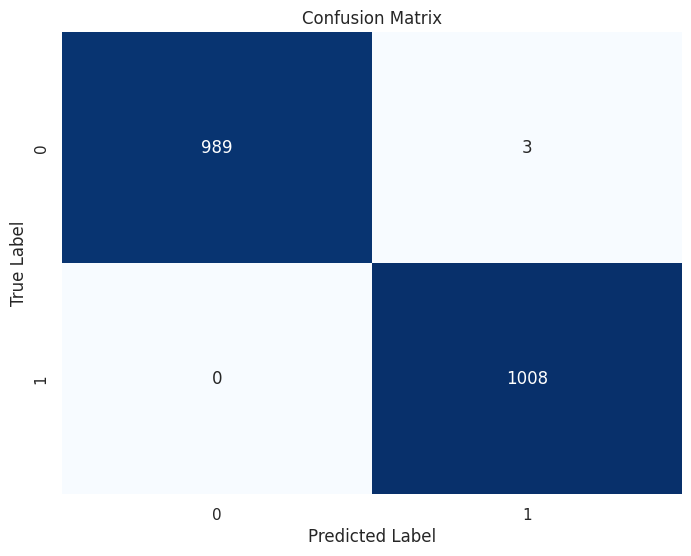

<Figure size 1000x600 with 0 Axes>

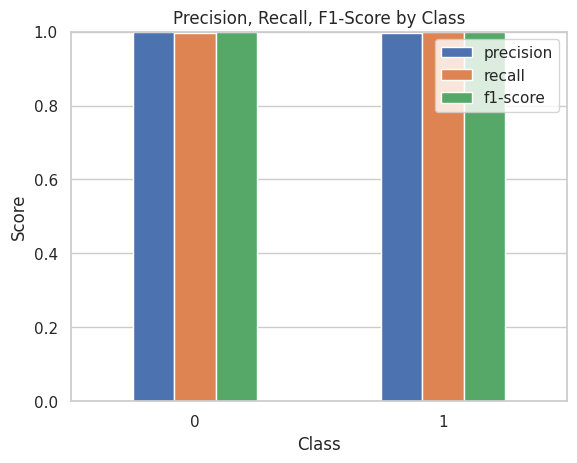

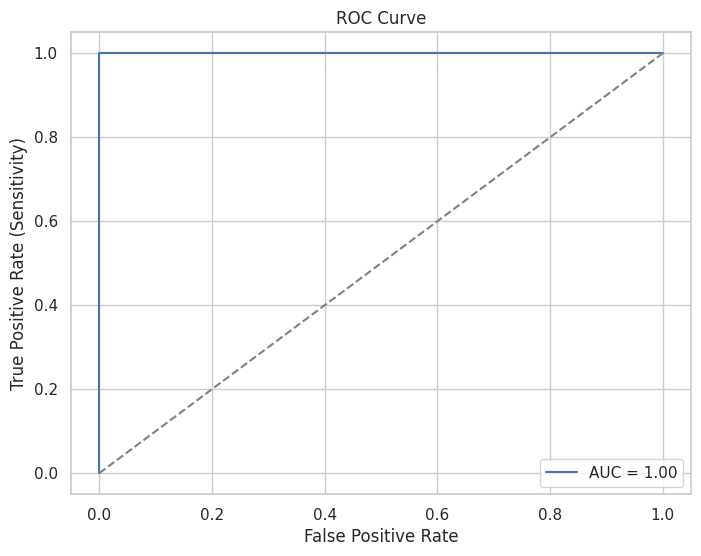

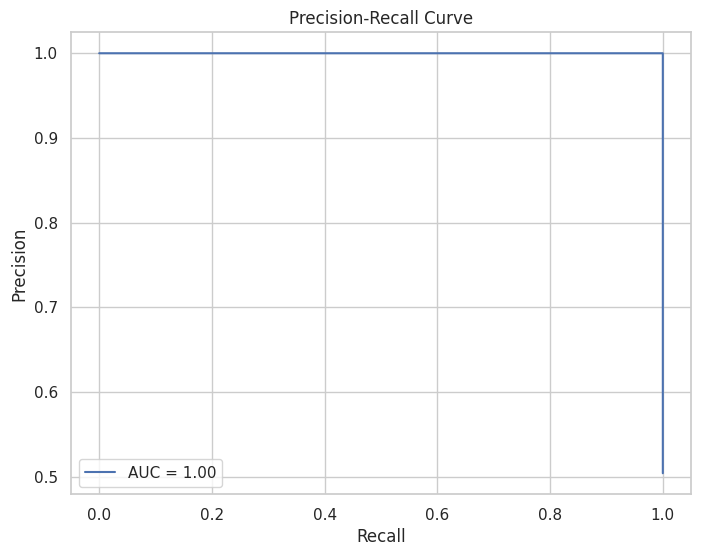

In [22]:
# Step 11: Get the best model
best_pipeline = random_search.best_estimator_

# Step 12: Evaluate the best model on the test split
y_pred_split = best_pipeline.predict(X_test_split)
print("Classification Report on CANCELLED/RETURNED/DELIVERED/IN PROCESS records:")
print(classification_report(y_test_split, y_pred_split))

# Step 13: Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test_split, y_pred_split)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 14: Classification Report (Precision, Recall, F1-Score) as a bar plot
report = classification_report(y_test_split, y_pred_split, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar')
plt.title('Precision, Recall, F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

# Step 15: ROC Curve and AUC (for binary classification tasks)
if len(best_pipeline.classes_) == 2:  # Check if binary classification
    # Predict probabilities for the positive class
    y_prob = best_pipeline.predict_proba(X_test_split)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_split, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Step 16: Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_split, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [34]:
for col in numerical_cols:
    mean_value = pd.to_numeric(df_train[col], errors='coerce').mean()  
    df_train[col].fillna(mean_value, inplace=True)


for col in categorical_cols:
    most_frequent = df_train[col].mode(dropna=True)[0] 
    df_train[col].fillna(most_frequent, inplace=True)

df_train['PREDICTED_CANCELLED_RETURNED'] =  best_pipeline.predict(df_train[numerical_cols + categorical_cols])

In [35]:
df_train

,DIVISION_CODE,DIVISION_NAME,BRAND_CODE,BRAND_NAME,CLASS_CODE,CLASS_NAME,SELLING_CHANNEL,CHAIN,WEB_ORDER_NUMBER,OMS_ORDER_NUMBER,OMS_LINE_ITEM_ID,OMS_TICKET_ID,SKU_ID,QUANTITY,UNIT_PRICE,CURRENT_STATUS,CURRENT_STATUS_DESCRIPTION,TRANSACTION_DATE,SHIP_FROM_WAREHOUSE_CODE,SHIP_FROM_WAREHOUSE_DESCRIPTION,ORDER_DATE,READY_TO_PRINT_DATE,PRINT_TICKET_DATE,VERIFIED_SHIPPED_DATE,BACK_ORDERED_DATE,ORDER_AGE,GIFT_ARTICLE_FLAG,CARRIER_NAME,CARRIER_TRACKING_NUMBER,DROPSHIP_FLAG,ORDER_STATUS,ORDER_CREATION_DATE,ORDER_CONFIRMATION_DATE,WM_ORDER_ID,WM_ORDER_LINE_ID,WM_ORDER_STATUS,WM_PICKING_START_TIME,WM_PICKING_END_TIME,WM_PICKING_AGE,WM_PACKING_START_TIME,WM_PACKING_END_TIME,WM_PACKING_AGE,WM_CREATED_DATE,WM_UPDATED_DATE,WM_SHIPPED_DATE,WM_ORDER_AGE,STORE_ID,STORE_NAME,SHIP_METHOD_CODE,SHIP_METHOD_NAME,SHIP_METHOD_SERVICE,SHIPMENT_SLA,NEW_ORDER_DATE,RETURN_REASON,RETURN_FLAG,RECORD_DATE,RECORD_TIME,GROSS_SALES,RETURNED_STATUS,SHIPPING_DELAY,TARGET,PREDICTED_CANCELLED_RETURNED
0,35,Designer Handbags,29645,STRATHBERRY,29,Top Handle,Online,Chain1,WC100004197473,51983375,51983375*1,51983375-1,301233898639,1,514.0,Cancelled,Cancelled,2024-03-20,5,Oakbrook,2024-10-20,NaT,NaT,NaT,09-03-2024,11,false,FedEx,******552558,false,Fulfilled,NaT,NaT,52356562-11,******,Shipped,NaT,NaT,0.461493,NaT,NaT,0.350061,NaT,NaT,2024-08-20,-3171.27494,9105,NA,FEDXH,FedEx Home Delivery,GROUND,NaN,2024-02-20,Size Issues,Partially Returned,<NA>,<NA>,514,CANCELLED,False,1,1
1,53,Beauty,11530,Dior,317,Makeup,Online,Chain1,WC100004184946,51961622,51961622*2,52356562-1,301123586110,1,34.0,Cancelled,Cancelled,2024-03-07,2,Northpark,2024-08-23,NaT,NaT,NaT,<NA>,0,false,FedEx,******552558,false,NA,1900-01-01,1900-01-01,52356562-11,******,Not in MAO,NaT,NaT,0.461493,NaT,NaT,0.350061,1900-01-01,1900-01-01,1900-01-01,-9999.00000,9105,NA,FEDXH,FedEx Home Delivery,GROUND,NaN,2023-03-30,Size Issues,Partially Returned,<NA>,<NA>,34,CANCELLED,False,1,1
2,35,Designer Handbags,11700,Saint Laurent,24,Cross Body,Online,Chain1,WC100004305635,52147466,52147466*1,52147466-1,301094710835,1,2700.0,Cancelled,Cancelled,2024-03-22,3,Tampa Bay,2024-06-19,2024-03-22 13:00:00,NaT,NaT,<NA>,1,false,FedEx,******552558,false,NA,1900-01-01,1900-01-01,52356562-11,******,Not in MAO,NaT,NaT,0.461493,NaT,NaT,0.350061,1900-01-01,1900-01-01,1900-01-01,-9999.00000,9105,NA,PAC1,PacMan Overnight,OVERNIGHT,NaN,2023-10-19,Size Issues,Partially Returned,<NA>,<NA>,2700,CANCELLED,False,1,1
3,21,Gifts & Home,11086,Charisma,745,Towels,Online,Chain3,WC300000688317,52012972,52012972*2,52012972-2,301085971429,4,10.0,Cancelled,Cancelled,2024-03-18,5,Oakbrook,2023-10-02,NaT,NaT,NaT,11-03-2024,7,false,FedEx SmartPost,******552558,false,Fulfilled,NaT,NaT,52356562-11,******,Shipped,NaT,NaT,0.461493,NaT,NaT,0.350061,NaT,NaT,2023-08-02,-3171.27494,9105,NA,FXPOS,FedEx SmartPost,GROUND,NaN,2023-02-02,Size Issues,Partially Returned,<NA>,<NA>,40,CANCELLED,False,1,1
4,14,Contemporary Apparel,45551,Sau Lee,124,Dress,Online,Chain1,WC100004148884,51900805,51900805*1,51900805-1,301237776803,1,458.0,Cancelled,Cancelled,2024-03-26,5,Oakbrook,2024-03-02,NaT,NaT,NaT,02-03-2024,24,false,FedEx SmartPost,******552558,false,Fulfilled,NaT,NaT,52356562-11,******,Shipped,NaT,NaT,0.461493,NaT,NaT,0.350061,NaT,NaT,2024-01-02,-3171.27494,9105,NA,FXPOS,FedEx SmartPost,GROUND,NaN,2023-04-06,Size Issues,Partially Returned,<NA>,<NA>,458,CANCELLED,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,Designer Handbags,11135,Christian Louboutin,20,Tote,Online,Chain1,WC100004262369,52085297,52085297*4,52085297-1,301232101358,-1,1950.0,Ready to Ship,Returned,2024-04-09,5,Oakbrook,2024-09-28,2024-03-17 19:20:01,2024-03-17 20:16:26,NaT,<NA>,23,false,FedEx,******669050,false,Fulfilled,NaT,NaT,52356562-11,******,Shipped,NaT,NaT,0.461493,NaT,NaT,0.35006

In [36]:
df_train[['RETURNED_STATUS', 'PREDICTED_CANCELLED_RETURNED']].value_counts()

RETURNED_STATUS  PREDICTED_CANCELLED_RETURNED
CANCELLED        1                               2500
DELIVERED        0                               2500
RETURNED         1                               2500
IN PROCESS       0                               2497
                 1                                  3
Name: count, dtype: int64

In [38]:
df_train.drop('PREDICTED_CANCELLED_RETURNED', axis=1, inplace=True)

In [ ]:

# # Importing the get_session function from fosforml's Snowflake session manager
# from fosforml.model_manager.snowflakesession import get_session

# # Establishing a Snowflake session for executing queries and performing operations
# my_session = get_session()

# # Define the name of the Snowflake table to query
# table_name = 'ORDER_DATA_2412'

# # Execute a SQL query to select all records from the specified table in Snowflake
# df_sample = my_session.sql("select * from {}".format(table_name)).to_pandas()

# df_sample

In [ ]:
# df_sample[categorical_cols]

In [ ]:
# df_sample.drop('PREDICTED_CANCELLED_RETURNED', axis=1, inplace=True)

In [ ]:
# df_sample.info()

In [39]:
# Convert the Pandas DataFrame (cust_df) into a Snowflake DataFrame
training_datadf = my_session.createDataFrame(df_train)

# Write the Snowflake DataFrame to a Snowflake table named 'casino_customers'
# The 'overwrite' mode ensures that the table is replaced if it already exists
training_datadf.write.mode("overwrite").save_as_table("ORDER_DATA_2412")


# Model deployment

In [46]:
y_pred = pd.DataFrame(y_pred)

In [47]:
from fosforml import register_model

register_model(
  model_obj=best_pipeline,
  session=my_session,
  x_train=X_train_split,
  y_train=y_train_split,
  x_test=X_test_split,
  y_test=y_test_split,
  y_pred=y_pred,
  source="Notebook",
  dataset_name="ORDER_DATA_2412",
  dataset_source="Snowflake",
  name="Returns_and_Cancellation",
  description="This is a Model for predicting the Returning and Cancellation orders",
  flavour="sklearn",
  model_type="classification",
  conda_dependencies=["scikit-learn==1.3.2"],
  verbose=True
)

"error, invalid inputs : TypeError('expected string or bytes-like object')"

In [49]:
X_train_split.dtypes

DIVISION_CODE                      string[pyarrow]
DIVISION_NAME                      string[pyarrow]
BRAND_CODE                         string[pyarrow]
BRAND_NAME                         string[pyarrow]
CLASS_CODE                         string[pyarrow]
CLASS_NAME                         string[pyarrow]
SELLING_CHANNEL                    string[pyarrow]
CHAIN                              string[pyarrow]
WEB_ORDER_NUMBER                   string[pyarrow]
OMS_ORDER_NUMBER                   string[pyarrow]
OMS_LINE_ITEM_ID                   string[pyarrow]
OMS_TICKET_ID                      string[pyarrow]
SKU_ID                             string[pyarrow]
QUANTITY                                      int8
UNIT_PRICE                                 float64
CURRENT_STATUS                     string[pyarrow]
CURRENT_STATUS_DESCRIPTION         string[pyarrow]
TRANSACTION_DATE                    datetime64[ns]
SHIP_FROM_WAREHOUSE_CODE           string[pyarrow]
SHIP_FROM_WAREHOUSE_DESCRIPTION